In [1]:
import os
import pydicom as dcm
import matplotlib.pyplot as plt
import numpy as np
# from tools import *
from anonymization import *

In [2]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    print("Intersept:", intercept)
    print("slope:", slope)
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [3]:
def find_dose_file(CT_path):
    dose_files = [f for f in os.listdir(CT_path) if 'RD' in f]
    num_dose_files = len(dose_files)
    
    if num_dose_files == 0:
        raise FileNoteFoundError("ERROR: NO DOSE FILES FOUND")
    
    RD = dcm.read_file(CT_path+dose_files[0]) 
    
    if num_dose_files == 1:
        return RD
    
    elif num_dose_files > 1:
        
        smallest_spacing = RD[0x0028, 0x0030]
        
        for dose_file in dose_files[1:]:
            rd = dcm.read_file(CT_path+dose_file)
            spacing = rd[0x0028, 0x0030]
            
            if spacing[0] <= smallest_spacing[0] and spacing[1] <= smallest_spacing[1]:
                smallest_spacing = spacing
                RD = rd 
            

    return RD

In [4]:
def resample_dose_map_2D(dose_map, new_spacing, old_spacing):

    scaling_factors = [old/new for old, new in zip(old_spacing,new_spacing)]
    original_size = np.array([len(dose_map), len(dose_map[0])]) # change to 3D
    
    new_size = (original_size*scaling_factors).astype(int)
    resampled_dose_map = np.zeros(new_size)

    # to do make 3d
    for i in range(new_size[0]):
        for j in range(new_size[1]):

            original_index = np.array([i,j])/scaling_factors
            resampled_dose_map[i][j] = dose_map[int(original_index[0]), int(original_index[1])]            
        
    return resampled_dose_map

In [5]:
def resample_dose_map_3D(dose_map, new_spacing, old_spacing):

    scaling_factors = [old/new for old, new in zip(old_spacing,new_spacing)]
    original_size = np.array([len(dose_map[0]), len(dose_map[0][0]),len(dose_map)]) # change to 3D
    
    print("OG SIZE",original_size)
    new_size_xyz = np.round(original_size*scaling_factors).astype(int)
    new_size = [new_size_xyz[2],new_size_xyz[0],new_size_xyz[1]]
    print("NEW SIZE",new_size)
    print("scaling factors",scaling_factors)
    print(original_size*scaling_factors)
    resampled_dose_map = np.zeros(new_size)
#     return resampled_dose_map
    print(resampled_dose_map.shape)

    # to do make 3d
    for k in range(new_size[0]):
        for i in range(new_size[1]):
            for j in range(new_size[2]):
           
#                 print(k)
                original_index = (np.array([i,j,k])/scaling_factors).astype(int)
#                 print(original_index)
#                 print(int(original_index[2]), int(original_index[0]),int(original_index[1]))
                resampled_dose_map[k][i][j] = dose_map[ int(original_index[2]), int(original_index[0]),int(original_index[1])]            

    return resampled_dose_map

In [6]:
def resize_dose_map(dose_map,new_size, spacing, new_origin, old_origin,default=0): # mode enlarge or shrink
#     if default==0:
    resized_dose_map = np.zeros(new_size)
#     else:
#         resized_dose_map = np.full((new_size), default)

#     print(resized_dose_map.shape)
    x_start = int((new_origin[0]-old_origin[0])/spacing[0])
    y_start = int((new_origin[1]-old_origin[1])/spacing[1])
    # print(x_img,y_img)
    # print((new_origin[0]-old_origin[0])/spacing[0],(new_origin[1]-old_origin[1])/spacing[1])
    # print("X",x_img, len(dose_map[0]))
    # print("Y",y_img, len(dose_map))
    # print(x_img+len(dose_map[0]))

    # if mode == 'enlarge':
    y_end = y_start+len(dose_map)
    x_end = x_start+len(dose_map[0])
    # print('xy ends',x_end,y_end)
    if y_end > 512:
        dose_map = dose_map[:(new_size[1]-y_end)]
    if x_end > 512:
        dose_map = dose_map[:,:(new_size[0]-x_end)]
    resized_dose_map[y_start:y_end,x_start:x_end] = dose_map
      
    # else:
          
    #     y_end = y_start+new_size[0]#len(dose_map)
    #     x_end = x_start+new_size[1]#len(dose_map[0])
            
    #     resized_dose_map = dose_map[y_start:y_end,x_start:x_end]
        


    # print('xy ends',x_end,y_end)
    # if y_end > 512:
    #     dose_map = dose_map[:(new_size[1]-y_end)]
    # if x_end > 512:
    #     dose_map = dose_map[:,:(new_size[0]-x_end)]
          
    # resized_dose_map[y_img:y_end,x_img:x_end] = dose_map



  
    return resized_dose_map

In [7]:
def resize_dose_map_3D(dose_map,new_size, spacing, new_origin, old_origin,default=0):
    new_size_zxy = new_size[2],new_size[0],new_size[1]
    print(new_size_zxy)
    resized_dose_map = np.zeros(new_size_zxy)
    z_image = int((new_origin[2] - old_origin[2])/spacing[2])
    print("z_img",z_image, (new_origin[2] - old_origin[2])/spacing[2])
    
    len_dose_map = len(dose_map)
    print("len dose map",len_dose_map)
    # Crop dose map if starting index is negative
    if z_image < 0:       
        z_image = 0
        len_dose_map = len_dose_map + z_image
    print("len dose map after < 0",len_dose_map)     
    
    for i,resized_index in enumerate(range(z_image,z_image+len_dose_map)):  # added zimage + lendose map. idk anymore
        print(i,resized_index)
        print("new or (DOSE)", new_origin[2])
        print("old or (IMG)", old_origin[2])
        print("spacing", spacing)
        resized_dose_map[resized_index] = resize_dose_map(dose_map[i],[new_size[0],new_size[1]],spacing,new_origin,old_origin,default=0)
    
    return resized_dose_map

In [8]:
PATH = '/mnt/iDriveShare/Kayla/CBCT_images/kayla_extracted/' # Path to patient files

In [9]:

patient = '115'
patient_path = PATH+patient+'/'
CT = [d for d in os.listdir(patient_path) if d[9:11] == 'CT' and len(d) == 23][0]
CT_dcm = dcm.read_file(PATH+patient+'/'+CT+'/'+[f for f in os.listdir(PATH+patient+'/'+CT) if 'CT' in f][0])
RS_file = [d for d in os.listdir(patient_path+CT) if d[0:2] == 'RS'][0]
RS = dcm.read_file(PATH+patient+'/'+CT+'/'+RS_file)
print(patient_path+CT)
# RD = find_dose_file(patient_path+CT+'/')
rds =[dcm.read_file(patient_path+CT+'/'+d) for d in os.listdir(patient_path+CT) if d[0:2] == 'RD']


/mnt/iDriveShare/Kayla/CBCT_images/kayla_extracted/115/20190501_CT_23_APR_2019


In [56]:
RD = rds[0]
dose_array = RD.pixel_array
dose_scaling = RD.DoseGridScaling
dose_gy = dose_array  * dose_scaling
print("RD1:",dose_array.shape)

RD2 = rds[1]
dose_array2 = RD2.pixel_array
dose_scaling2 = RD2.DoseGridScaling
dose_gy2 = dose_array2  * dose_scaling2
print("RD2:",dose_array2.shape)

RD3 = rds[2]
dose_array3 = RD3.pixel_array
dose_scaling3 = RD3.DoseGridScaling
dose_gy3 = dose_array3  * dose_scaling3
print("RD3:",dose_array3.shape)

RD1: (402, 238, 516)
RD2: (402, 238, 516)
RD3: (177, 208, 243)


IndexError: index 300 is out of bounds for axis 0 with size 177

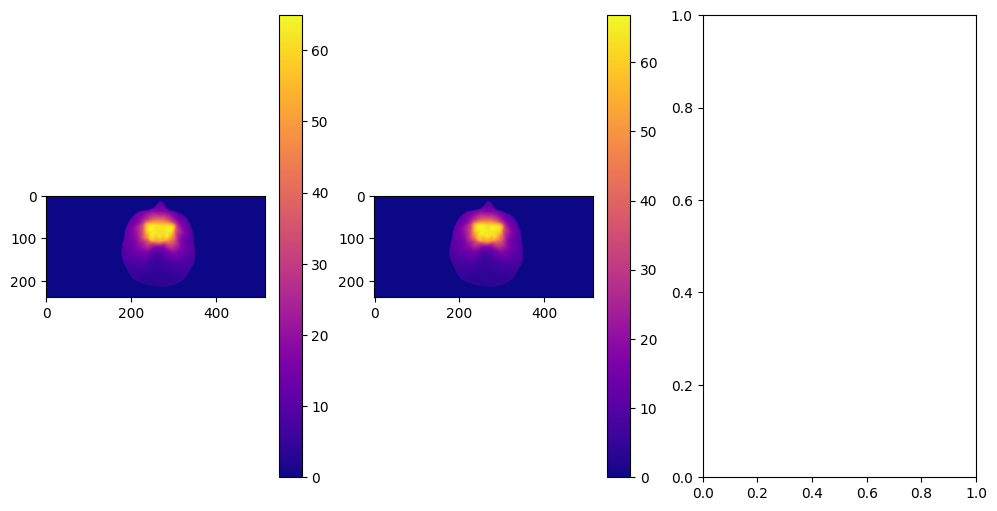

In [83]:
# plt.imshow(dose_gy[img_slice],cmap=plt.cm.plasma)
# plt.colorbar(label="Dose (Gy)")
img_slice = 300

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(dose_gy[img_slice],cmap=plt.cm.plasma)
plt.colorbar(label="")
# plt.title('Mask in image space\n'+str(mask.shape))
plt.subplot(1,3,2)
plt.imshow(dose_gy2[img_slice],cmap=plt.cm.plasma)
plt.colorbar(label="")
# plt.title('Mask sized but not \n sampled in dose map space\n'+str(m_rev.shape))
plt.subplot(1,3,3)
plt.imshow(dose_gy3[img_slice],cmap=plt.cm.plasma)
plt.colorbar(label="")
# plt.title('all in dose map space\n'+str(mask_rev.shape))

In [80]:
for RD in rds:
    print("****************************")
    print("date",RD.StudyDate, RD.StudyTime)
    print("Series number",RD.SeriesNumber)
    print("positions",RD.ImagePositionPatient, RD.ImageOrientationPatient)
    print("Units",RD.DoseUnits)
    print("Type",RD.DoseType)
    print("Sum type",RD.DoseSummationType)
    print("Samples per pixel",RD.SamplesPerPixel)
    print("Rows",RD.Rows)
    print("Cols",RD.Columns)
    print("# Frames",RD.NumberOfFrames)
    print("pixel spacing",RD.PixelSpacing)
    print("z-spacing?",RD.GridFrameOffsetVector[1]-RD.GridFrameOffsetVector[0])
    print("dose scaling",RD.DoseGridScaling)

****************************
date 20190423 160428
Series number 16
positions [-267.26147, -25.66142066, -671.5] [1, 0, 0, 0, 1, 0]
Units GY
Type PHYSICAL
Sum type PLAN
Samples per pixel 1
Rows 238
Cols 516
# Frames 402
pixel spacing [1, 1]
z-spacing? 1.0
dose scaling 7.0076776811e-05
****************************
date 20190423 160428
Series number 18
positions [-267.26147, -25.66142066, -671.5] [1, 0, 0, 0, 1, 0]
Units GY
Type PHYSICAL
Sum type PLAN
Samples per pixel 1
Rows 238
Cols 516
# Frames 402
pixel spacing [1, 1]
z-spacing? 1.0
dose scaling 7.0077084793e-05
****************************
date 20190423 160428
Series number 54154
positions [-121.26147, -23.66142066, -542.5] [1, 0, 0, 0, 1, 0]
Units GY
Type PHYSICAL
Sum type PLAN
Samples per pixel 1
Rows 208
Cols 243
# Frames 177
pixel spacing [1, 1]
z-spacing? 1.0
dose scaling 7.0077084793e-05


In [67]:
RD

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 190
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Dose Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.246.352.221.486349929593213310217939343637702887327
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.246.352.70.2.1.160.3
(0002, 0013) Implementation Version Name         SH: 'DCIE 2.2'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0012) Instance Creation Date              DA: '20230707'
(0008, 0013) Instance Creation Time              TM: '103340'
(0008, 0016) SOP Class UID                       UI: RT Dose Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.246.352.221.486349929593213310217939343637702887327
(0008, 00

In [45]:
# RD  = RD3

In [57]:
slices = [dcm.read_file(PATH+patient+'/'+CT + '/'+ s) for s in os.listdir(PATH+patient+'/'+CT) if 'CT' in s]
slices.sort(key = lambda x: (x.InstanceNumber))
image = get_pixels_hu(slices)
# Image Sacping Parameters
origin = slices[0].ImagePositionPatient
start_z = origin[2]
start_x = origin[0]
start_y = origin[1]
z_spacing = slices[0].SliceThickness 
pixel_spacing = slices[0].PixelSpacing
spacing = [pixel_spacing[0],pixel_spacing[1],z_spacing]

# Spacing in Z,X,Y format
dose_spacing = [RD.GridFrameOffsetVector[1]-RD.GridFrameOffsetVector[0],RD.PixelSpacing[0],RD.PixelSpacing[1]]
CT_spacing = [CT_dcm.SliceThickness,pixel_spacing[0],pixel_spacing[1]]

Intersept: -1000
slope: 1


In [58]:
dose_spacing = [RD.PixelSpacing[0],RD.PixelSpacing[1],RD.GridFrameOffsetVector[1]-RD.GridFrameOffsetVector[0]]
CT_spacing = [pixel_spacing[0],pixel_spacing[1],CT_dcm.SliceThickness]

In [59]:
xpos = np.arange(RD.Columns)*RD.PixelSpacing[0]+RD.ImagePositionPatient[0]
ypos = np.arange(RD.Rows)*RD.PixelSpacing[1]+RD.ImagePositionPatient[1]
zpos = np.asarray(RD.GridFrameOffsetVector) + RD.ImagePositionPatient[2]

In [60]:
r3 = resample_dose_map_3D(dose_gy,CT_spacing, dose_spacing)

OG SIZE [238 516 402]
NEW SIZE [134, 200, 434]
scaling factors [0.8407224994289813, 0.8407224994289813, 0.3333333333333333]
[200.09195486 433.81280971 134.        ]
(134, 200, 434)


In [61]:
r3.shape

(134, 200, 434)

In [62]:
r_r3 = resize_dose_map_3D(r,[512,512,len(image)],[pixel_spacing[0],pixel_spacing[1],CT_dcm.SliceThickness], RD.ImagePositionPatient,[start_x,start_y,start_z])

(135, 512, 512)
z_img 0 -0.3333333333333333
len dose map 134
len dose map after < 0 134
0 0
new or (DOSE) -671.5
old or (IMG) -670.5
spacing ['1.18945312', '1.18945312', '3.0']
1 1
new or (DOSE) -671.5
old or (IMG) -670.5
spacing ['1.18945312', '1.18945312', '3.0']
2 2
new or (DOSE) -671.5
old or (IMG) -670.5
spacing ['1.18945312', '1.18945312', '3.0']
3 3
new or (DOSE) -671.5
old or (IMG) -670.5
spacing ['1.18945312', '1.18945312', '3.0']
4 4
new or (DOSE) -671.5
old or (IMG) -670.5
spacing ['1.18945312', '1.18945312', '3.0']
5 5
new or (DOSE) -671.5
old or (IMG) -670.5
spacing ['1.18945312', '1.18945312', '3.0']
6 6
new or (DOSE) -671.5
old or (IMG) -670.5
spacing ['1.18945312', '1.18945312', '3.0']
7 7
new or (DOSE) -671.5
old or (IMG) -670.5
spacing ['1.18945312', '1.18945312', '3.0']
8 8
new or (DOSE) -671.5
old or (IMG) -670.5
spacing ['1.18945312', '1.18945312', '3.0']
9 9
new or (DOSE) -671.5
old or (IMG) -670.5
spacing ['1.18945312', '1.18945312', '3.0']
10 10
new or (DOSE) -6

In [63]:
r_r3.shape

(135, 512, 512)

In [ ]:
# x_iso = []
# y_iso = []
# for i,row in enumerate(r_r[99]):
#     for j, col in enumerate(row):
#         if col == 1:
#             x_iso.append(xpos[j])
#             y_iso.append(ypos[i])



In [28]:
y_cutoff,z_lists,y_cutoff_roi,z_smg =  get_eye_contours(RS,start_x,start_y,start_z,z_spacing,pixel_spacing)

['Eye_R', 'Eye_L']
Centre ROI slice: 104


In [29]:
cut_above = True
reverse_z = False
keywords_keep = ['brain','PTV']

list_names_keep = []
for keyword in keywords_keep:
    list_names_keep = list_names_keep + find_ROI_names(RS,keyword=keyword)


dict_contours_keep,_ = get_all_ROI_contours(list_names_keep,RS)
contours_to_keep = dict_contours_keep
# new_dicom = anon_dicom(anon, slices)
#todotoday - uncomment below
# save_dicom(new_dicom,save_path,patient,CT_file)

In [30]:
anon_image = image.copy()

all_z_slices = sorted(z_lists[0] + [z for z in z_lists[1] if z not in z_lists[0]])
img_slices = [get_image_slice(start_z, z, spacing) for z in all_z_slices]


z_min = min(img_slices)
z_max = max(img_slices)

if cut_above:
    if reverse_z:
        z_min = 0
    else:
        z_max = len(image)


mask = np.full_like(image,1)
mask[z_min:z_max+1,0:int(y_cutoff)+1,:] = 0

for contour in contours_to_keep:
    for c_slice in contours_to_keep[contour]:
        slice_num = get_image_slice(start_z, c_slice[2], spacing)
        if slice_num >= z_min and slice_num <= z_max:
            xi, yi, zi = c_slice[::3], c_slice[1::3], c_slice[2::3]
            X,Y,Z = xyz_to_image_coords(xi,yi,zi,spacing,origin)

            cont_xy = np.array([tuple([int(x),int(y)]) for x,y in zip(X,Y)])
            cont_xy = cont_xy.reshape((-1,1,2))
            cv2.drawContours(mask[slice_num],[cont_xy],-1,1, -1)
            #TO DO IUSE THIS TOCROP OTEHR CINTIURS

# anon_image*mask++(mask*-1+1)*(-1000)

In [42]:
s = 100

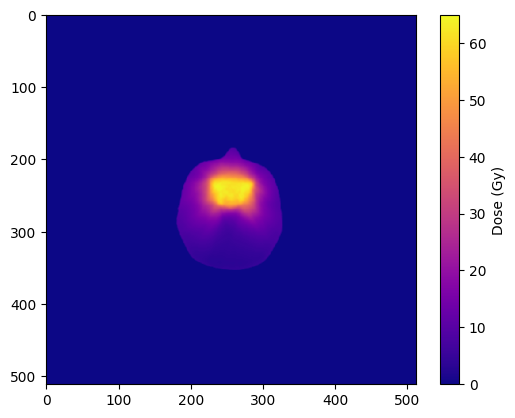

In [64]:
plt.imshow(r_r3[s],cmap=plt.cm.plasma)
plt.colorbar(label="Dose (Gy)")

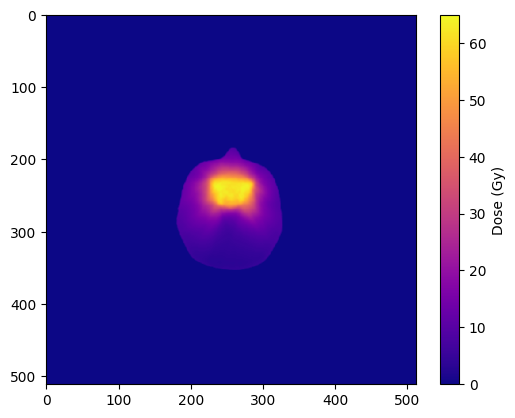

In [43]:
plt.imshow(r_r[s],cmap=plt.cm.plasma)
plt.colorbar(label="Dose (Gy)")

In [38]:
r_r.shape

(135, 512, 512)

In [39]:
mask.shape

(135, 512, 512)

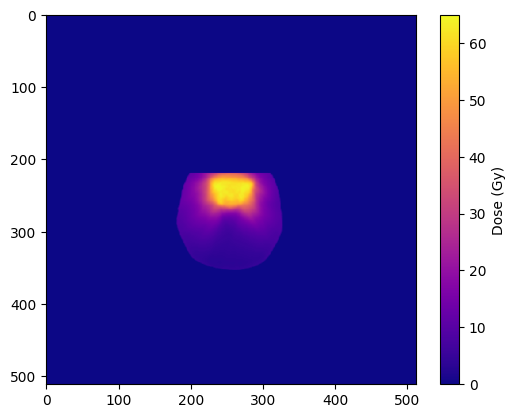

In [44]:
plt.imshow((r_r*mask)[s],cmap=plt.cm.plasma)
plt.colorbar(label="Dose (Gy)")

(402, 238, 516)


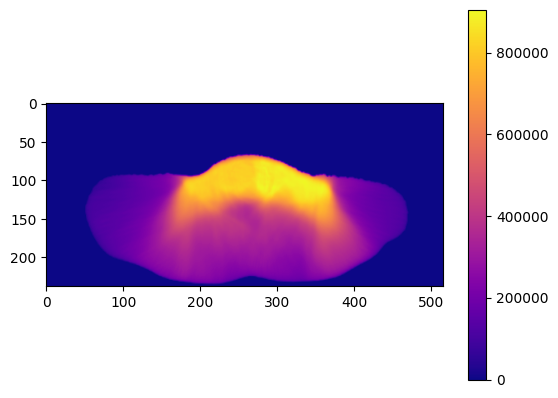

In [36]:
dose_array = RD.pixel_array
dose_scaling = RD.DoseGridScaling
# dose_gy = dose_array  * dose_scaling # dont need to scale to Gy
print(dose_array.shape)
plt.imshow(dose_array[115],cmap=plt.cm.plasma)
plt.colorbar(label="")

In [252]:
dose_spacing = [RD.PixelSpacing[0],RD.PixelSpacing[1],RD.GridFrameOffsetVector[1]-RD.GridFrameOffsetVector[0]]
CT_spacing = [pixel_spacing[0],pixel_spacing[1],CT_dcm.SliceThickness]
print("Dose spacing:",dose_spacing)
print("CT Spacing:",CT_spacing)

Dose spacing: ['2.5', '2.5', 3.0]
CT Spacing: ['1.1640625', '1.1640625', '3.0']


In [253]:
original_dose_size = [dose_array.shape[2],dose_array.shape[1],dose_array.shape[0]]
print(original_dose_size)

[217, 112, 132]


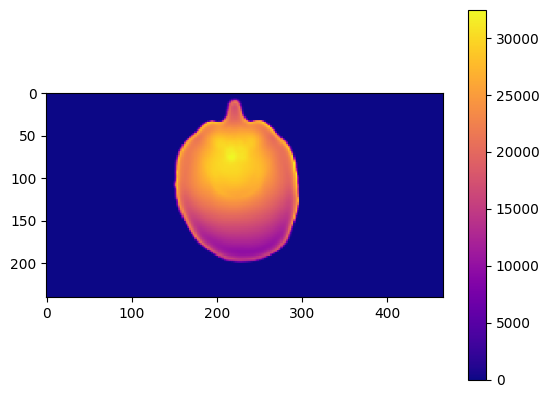

In [254]:
plt.imshow(r[100],cmap=plt.cm.plasma)
plt.colorbar(label="")

In [255]:
r_r = resize_dose_map_3D(r,[512,512,len(image)],[pixel_spacing[0],pixel_spacing[1],CT_dcm.SliceThickness], RD.ImagePositionPatient,[start_x,start_y,start_z])

(139, 512, 512)
z_img 0 0.0
len dose map 132
len dose map after < 0 132
0 0
new or (DOSE) -728.5
old or (IMG) -728.5
spacing ['1.1640625', '1.1640625', '3.0']
30 135
30.151772520805356 135.95680436402685
X 30 466
Y 135 240
496
xy ends 496 375
1 1
new or (DOSE) -728.5
old or (IMG) -728.5
spacing ['1.1640625', '1.1640625', '3.0']
30 135
30.151772520805356 135.95680436402685
X 30 466
Y 135 240
496
xy ends 496 375
2 2
new or (DOSE) -728.5
old or (IMG) -728.5
spacing ['1.1640625', '1.1640625', '3.0']
30 135
30.151772520805356 135.95680436402685
X 30 466
Y 135 240
496
xy ends 496 375
3 3
new or (DOSE) -728.5
old or (IMG) -728.5
spacing ['1.1640625', '1.1640625', '3.0']
30 135
30.151772520805356 135.95680436402685
X 30 466
Y 135 240
496
xy ends 496 375
4 4
new or (DOSE) -728.5
old or (IMG) -728.5
spacing ['1.1640625', '1.1640625', '3.0']
30 135
30.151772520805356 135.95680436402685
X 30 466
Y 135 240
496
xy ends 496 375
5 5
new or (DOSE) -728.5
old or (IMG) -728.5
spacing ['1.1640625', '1.164

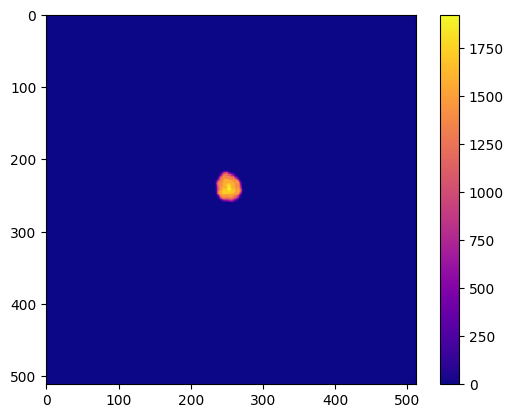

In [260]:
plt.imshow(r_r[131],cmap=plt.cm.plasma)
plt.colorbar(label="")

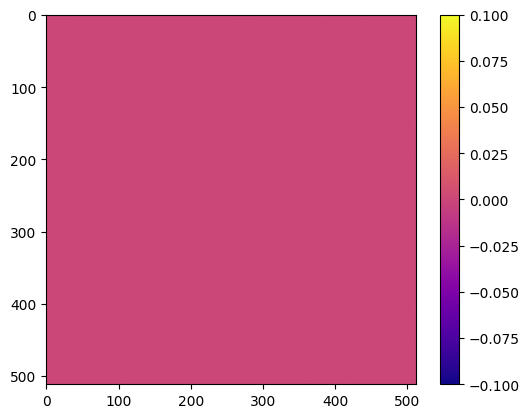

In [264]:
anon_rd = r_r*mask
plt.imshow(anon_rd[138],cmap=plt.cm.plasma)
plt.colorbar(label="")

In [173]:
# def reverse_resize_dose_map(resized_dose_map, new_size, spacing, original_origin, new_origin, default=0):
#     dose_map = np.zeros(new_size)
#     print("dose map size",dose_map.shape)
  
    
#     x_img = int((original_origin[0] - new_origin[0]) / spacing[0])
#     y_img = int((original_origin[1] - new_origin[1]) / spacing[1])
    
#     y_end = min(y_img + resized_dose_map.shape[0], dose_map.shape[0])
#     x_end = min(x_img + resized_dose_map.shape[1], dose_map.shape[1])
    
#     resized_y_end = y_end - y_img
#     resized_x_end = x_end - x_img
#     print("Resized y , x end:",resized_y_end,resized_x_end)
    
#     dose_map[y_img:y_end, x_img:x_end] = resized_dose_map[:resized_y_end, :resized_x_end]
#     return dose_map


In [366]:
# def reverse_resize_dose_map_3D(resized_dose_map, new_size, spacing, new_origin,original_origin, default=0):
#     dose_map = np.zeros(new_size)
#     print("dose map size",dose_map.shape)
    
#     z_image = int((original_origin[2] - new_origin[2]) / spacing[2])
    
#     for i, resized_index in enumerate(range(z_image, z_image + resized_dose_map.shape[0])):
#         if resized_index < dose_map.shape[0]:
#             dose_map[resized_index] = reverse_resize_dose_map(
#                 resized_dose_map[i], (new_size[1], new_size[2]), spacing,  new_origin,original_origin, default=0,
#             )
    
#     return dose_map


In [370]:
def reverse_resize_dose_map(dose_map,new_size, spacing,  old_origin,new_origin,default=0):
#     if default==0:
    resized_dose_map = np.zeros(new_size)
#     else:
#         resized_dose_map = np.full((new_size), default)

#     print(resized_dose_map.shape)
    x_start = int((new_origin[0]-old_origin[0])/spacing[0])
    y_start = int((new_origin[1]-old_origin[1])/spacing[1])
  
    # print("Z",z_start)
    # print(x_start,y_start)
    # print((new_origin[0]-old_origin[0])/spacing[0],(new_origin[1]-old_origin[1])/spacing[1])
    # print("X",x_start, len(dose_map[0]))
    # print("Y",y_start, len(dose_map))
    # print(x_start+len(dose_map[0]))
    
    y_end = y_start+new_size[0]#len(dose_map)
    x_end = x_start+new_size[1]#len(dose_map[0])
        
    resized_dose_map = dose_map[y_start:y_end,x_start:x_end]
    


    # print('xy ends',x_end,y_end)
    # if y_end > 512:
    #     dose_map = dose_map[:(new_size[1]-y_end)]
    # if x_end > 512:
    #     dose_map = dose_map[:,:(new_size[0]-x_end)]
          
    # resized_dose_map[y_img:y_end,x_img:x_end] = dose_map
    return resized_dose_map

In [374]:
def reverse_resize_dose_map_3D(dose_map,new_size, spacing, new_origin, old_origin,default=0):
    new_size_zxy = new_size[0],new_size[1],new_size[2]
    # print(new_size_zxy)
    resized_dose_map = np.zeros(new_size_zxy)
    z_image = int((new_origin[2] - old_origin[2])/spacing[2])
    # print("z_img",z_image, (new_origin[2] - old_origin[2])/spacing[2])
    
    len_dose_map = len(dose_map)
    # print("len dose map",len_dose_map)
    # Crop dose map if starting index is negative
    if z_image < 0:       
        z_image = 0
        len_dose_map = len_dose_map + z_image
    # print("len dose map after < 0",len_dose_map)    
    
    z_start = int((new_origin[2]-old_origin[2])/spacing[2])
    
    for i,resized_index in enumerate(range(z_image,z_image+new_size[0])):  # added zimage + lendose map. idk anymore
        # if i > lennew_size[0]
        # print(i,resized_index)
        # print("new or (DOSE)", new_origin[2])
        # print("old or (IMG)", old_origin[2])
        # print("spacing", spacing)
        resized_dose_map[resized_index] = reverse_resize_dose_map(dose_map[i],[new_size[1],new_size[2]],spacing,new_origin,old_origin,default=0)
    
    return resized_dose_map

In [375]:
original_dose_size #z y x

(132, 240, 466)

In [376]:
original_dose_size = r.shape# dose_array.shape
r_rev = reverse_resize_dose_map_3D(anon_rd,original_dose_size,[pixel_spacing[0],pixel_spacing[1],CT_dcm.SliceThickness], [start_x,start_y,start_z],RD.ImagePositionPatient)

In [377]:
original_dose_size = r.shape# dose_array.shape
r_rev = reverse_resize_dose_map_3D(anon_rd,original_dose_size,[pixel_spacing[0],pixel_spacing[1],CT_dcm.SliceThickness], [start_x,start_y,start_z],RD.ImagePositionPatient)

Text(0.5, 1.0, 'Before defcaing')

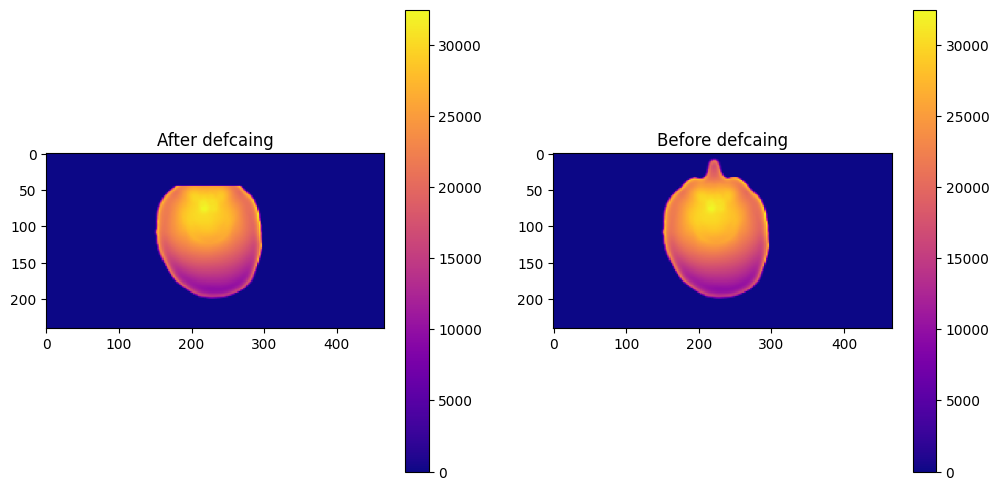

In [378]:

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(r_rev[100],cmap=plt.cm.plasma)
plt.colorbar(label="")
plt.title("After defcaing")
plt.subplot(1,2,2)
plt.imshow(r[100],cmap=plt.cm.plasma)
plt.colorbar(label="")
plt.title("Before defcaing")

In [379]:
dose_array_rev =  resample_dose_map_3D(r_rev, dose_spacing,CT_spacing)

[240 466 132]
[132, 111, 216]
[111.75    216.98125 132.     ]
(132, 111, 216)


Text(0.5, 1.0, 'Before defcaing')

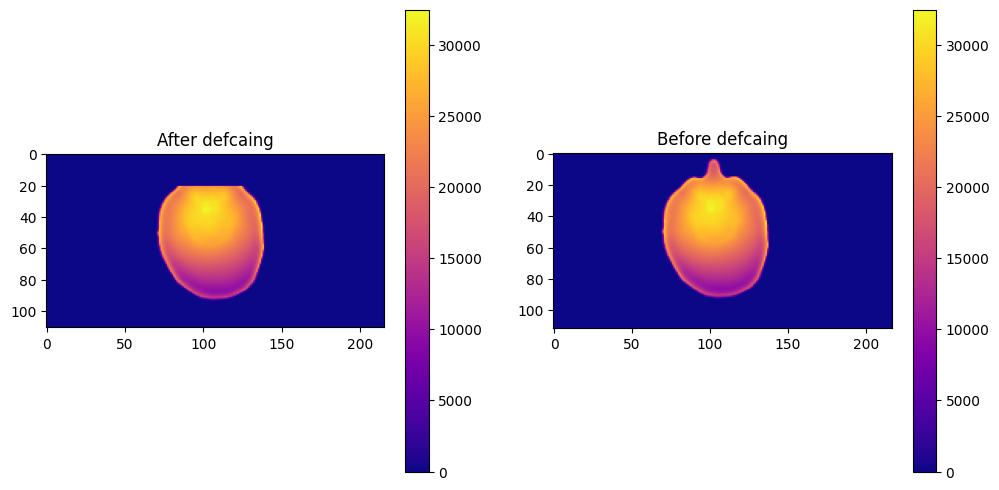

In [348]:

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(dose_array_rev[100],cmap=plt.cm.plasma)
plt.colorbar(label="")
plt.title("After defcaing")
plt.subplot(1,2,2)
plt.imshow(dose_array[100],cmap=plt.cm.plasma)
plt.colorbar(label="")
plt.title("Before defcaing")

In [349]:
RD.ImagePositionPatient

[-262.9014523, -37.73778242, -728.5]

In [179]:
origin

[-298, -196, -728.5]

In [410]:
print(original_dose_size,[pixel_spacing[0],pixel_spacing[1],CT_dcm.SliceThickness], [start_x,start_y,start_z],RD.ImagePositionPatient)

(132, 240, 466) ['1.1640625', '1.1640625', '3.0'] ['-298.0', '-196.0', '-728.5'] [-262.9014523, -37.73778242, -728.5]


In [250]:
r_r.shape

(139, 512, 512)

In [251]:
r.shape

(132, 240, 466)

In [406]:
m_rev = reverse_resize_dose_map_3D(mask,original_dose_size,[pixel_spacing[0],pixel_spacing[1],CT_dcm.SliceThickness], [start_x,start_y,start_z],RD.ImagePositionPatient)
mask_rev =  resample_dose_map_3D(m_rev, dose_spacing,CT_spacing)

OG SIZE [240 466 132]
NEW SIZE [132, 112, 217]
scaling factors [0.465625, 0.465625, 1.0]
[111.75    216.98125 132.     ]
(132, 112, 217)


Text(0.5, 1.0, 'all in dose map space\n(132, 112, 217)')

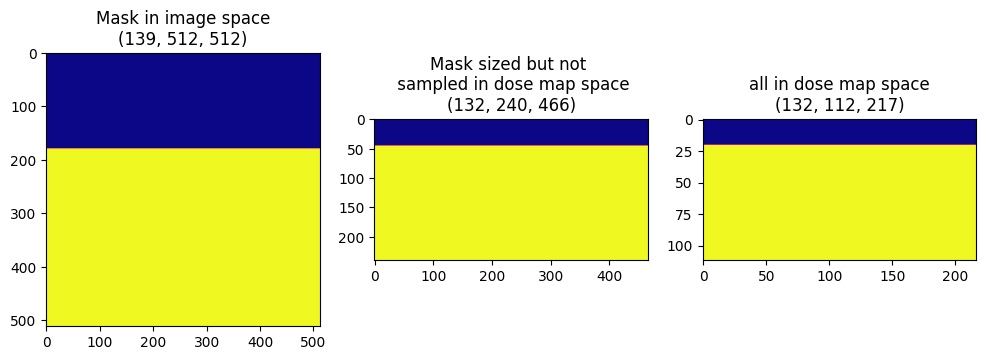

In [407]:

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(mask[100],cmap=plt.cm.plasma)
plt.title('Mask in image space\n'+str(mask.shape))
plt.subplot(1,3,2)
plt.imshow(m_rev[100],cmap=plt.cm.plasma)
plt.title('Mask sized but not \n sampled in dose map space\n'+str(m_rev.shape))
plt.subplot(1,3,3)
plt.imshow(mask_rev[100],cmap=plt.cm.plasma)
plt.title('all in dose map space\n'+str(mask_rev.shape))

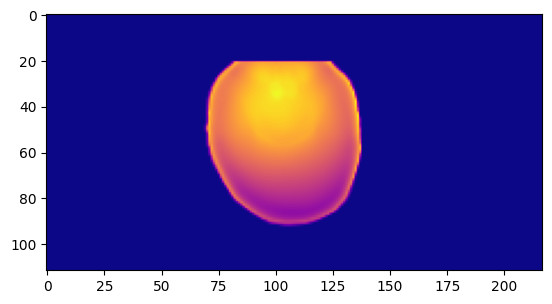

In [408]:
# plt.subplot(1,3,3)
plt.imshow((mask_rev*dose_array)[100],cmap=plt.cm.plasma)

In [ ]:
dis

In [392]:
dose_array.shape

(132, 112, 217)

In [389]:
# #issue at border 
# for i in range(len(mask_rev)):
#     for j in range(len(mask_rev[i])):
#         for k in range(len(mask_rev[i][j])):
#             if mask_rev[i][j][k] != 1 and mask_rev[i][j][k] != 0:
#                 print(mask_rev[i][j][k])